# Sentiment Analysis using Bay Area Restaurant Yelp Reviews

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd

In [4]:
from tqdm import tqdm_notebook as tqdm

In [5]:
import sys
sys.path.insert(1, '../tools')
from data_tools import *

In [8]:
from nltk.tokenize import RegexpTokenizer
import re

# Data Preparation

In [6]:
bay_area_demo = pd.read_csv('../data/bay_area_demography.csv')
all_businesses_info = pd.read_csv('../data/all_businesses_info.csv')
all_reviews = pd.read_csv('../data/all_reviews.csv')

## Clean text

In [9]:
def processed_text(in_str):
    lower_str = in_str.lower()
    splited_str = re.split(r'[.\s]', lower_str)
    return splited_str

In [10]:
def clean_text(in_str):
    """ clean an input str by
        1. lower it
        2. removed all punctuations and symbols
    """
    after_re = [re.sub(r'^[/\_\W]+|[\_\W]+$|\d|\n', '', i) for i in in_str]
    processed = [i for i in after_re if i != '']
    return processed

In [11]:
texts = [clean_text(processed_text(i)) for i in tqdm(all_reviews['text'])]
texts = [clean_text(i) for i in tqdm(texts)]
texts = [' '.join(i) for i in texts]

In [12]:
labels = all_reviews['rating'].values
binary_labels = [0 if i <= 3 else 1 for i in labels]

In [13]:
texts_labels = pd.DataFrame({'texts':texts, 'labels':labels, 'binary_labels':binary_labels})
texts_labels = texts_labels.sample(frac=1).reset_index(drop=True)

__Output the cleaned text to .csv__

In [119]:
texts_labels['reviews_id'] = all_reviews.id

In [122]:
# texts_labels[['texts','labels','reviews_id']].to_csv('../data/cleaned_texts.csv', index=False)

## Class Balance

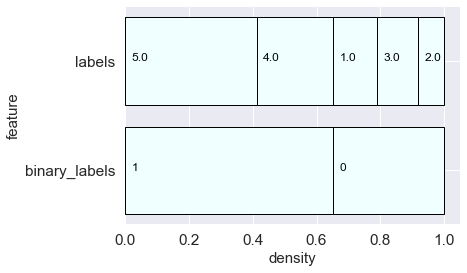

In [650]:
# I won't worry too much here
# However, will defenitely inspect model accuracy on class prediction performance
discrete_inspector(texts_labels, col_name=['binary_labels','labels'])

## Train Test Split

In [14]:
train_ratio = 0.8
train_cutoff = round(texts_labels.shape[0]*train_ratio)

In [15]:
# splitted data as a dataframe
train_data = texts_labels.iloc[range(0,train_cutoff)]
test_data = texts_labels.iloc[range(train_cutoff, texts_labels.shape[0])]

In [216]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

In [169]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

In [171]:
import matplotlib.pyplot as plt
import seaborn as sns

# Model - Multinomial Naive Bayes

In [213]:
def run_pipeline(in_df, train_idx, test_idx, pipeline):
    """ run a pipeline, crate for k-folds cross-validation
    """
    train_set = in_df.iloc[train_idx]
    train_X = train_set.texts
    train_y = train_set.binary_labels

    test_set = in_df.iloc[test_idx]
    test_X = test_set.texts
    test_y = test_set.binary_labels

    my_model = pipeline.fit(train_X, train_y)
    pred = my_model.predict(test_X)
    score = (pred == test_y).sum() / test_X.shape[0]
    prob = my_model.predict_proba(test_X)

    return score, pred, test_y.values, prob

In [195]:
steps = [
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer(use_idf=True, smooth_idf=True)),
    ('NB', MultinomialNB(alpha=1))]
nb_pipline = Pipeline(steps)

In [196]:
kf = KFold(n_splits=10)
nb_cv_results = [run_pipeline(texts_labels, i, j, nb_pipline) for i,j in kf.split(train_data)]

In [197]:
mean_acc_nb = np.array([i[0] for i in nb_cv_results]).mean()
print('Mean Models Accuracy: {}'.format(mean_acc_nb))

Mean Models Accuracy: 0.7963726393572881


In [198]:
nb_pred = np.concatenate([i[1] for i in nb_cv_results])
nb_actu = np.concatenate([i[2] for i in nb_cv_results])
nb_prob = np.concatenate([i[3] for i in nb_cv_results])

## Confusion Matrix

In [199]:
con_matrix_nb = confusion_matrix(nb_actu, nb_pred)

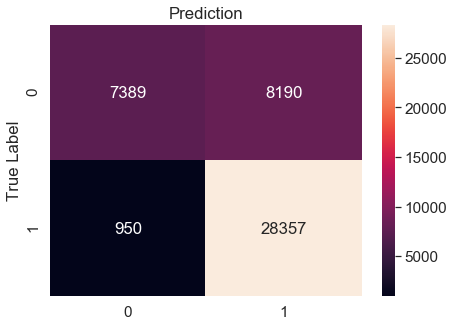

In [200]:
plt.figure(figsize=(7,5))
sns.set(font_scale=1.4)
sns.heatmap(con_matrix_nb, annot=True, fmt="d")
plt.ylabel('True Label')
plt.title('Prediction')
plt.show()

## Precision & Recalls

In [201]:
class_report_nb = classification_report(nb_actu, nb_pred, \
                                     target_names=['negative_reveiws', 'positive_reviews'])
print(class_report_nb)

                  precision    recall  f1-score   support

negative_reveiws       0.89      0.47      0.62     15579
positive_reviews       0.78      0.97      0.86     29307

        accuracy                           0.80     44886
       macro avg       0.83      0.72      0.74     44886
    weighted avg       0.81      0.80      0.78     44886



## ROC AUC

In [208]:
fpr_nb, tpr_nb, thresholds_nb = roc_curve(nb_actu, nb_prob[:,1])

In [209]:
auc_nb = auc(fpr_nb, tpr_nb)

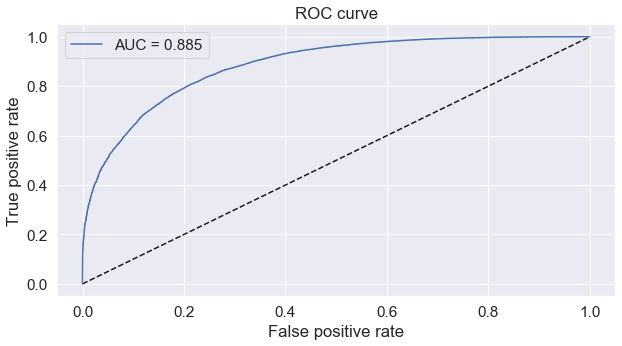

In [210]:
plt.figure(figsize=(10,5))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_nb, tpr_nb, label='AUC = {:.3f}'.format(auc_nb))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# Model - Regularized Logistic Regression (Lasso)

In [559]:
vocab = CountVectorizer(ngram_range=(1,2)).fit(texts_labels.texts).get_feature_names()

In [560]:
lr_steps = [
    ('vectorizer', CountVectorizer(vocabulary=vocab, stop_words='english')),
    ('tfidf', TfidfTransformer(use_idf=True, smooth_idf=True)),
    ('log_reg', LogisticRegression(penalty='l1', solver='liblinear', C=0.1))]
lr_pipline = Pipeline(lr_steps)

In [561]:
try_ = lr_pipline.fit(texts_labels.texts, texts_labels.binary_labels)

In [562]:
def plot_strength(strength, label, range_, x_lim=None):
    # components
    range_diff = range_[1] - range_[0]
    strength_ = np.array(strength)
    label_ = np.array(label)
    range_list = list(range(range_[0], range_[1]))

    selected_strength = strength_[range_list]
    max_strength_ = max(selected_strength)
    min_strength_ = min(selected_strength)
    plot_lim = np.max(np.abs(np.array([max_strength_, min_strength_])))
    plot_labels = label_[range_list]

    # data prep
    neg = []
    pos = []
    for i in selected_strength:
        if i <0:
            pos.append(0)
            neg.append(i)
        else:
            pos.append(i)
            neg.append(0)

    # plot
    plt.barh(range(range_diff), pos)
    plt.barh(range(range_diff), neg)
    for i,j in enumerate(plot_labels):
        plt.annotate(j, (max_strength_+2, i-0.1))
    if x_lim is None:
        plt.xlim(-plot_lim-3,plot_lim+3)
    else:
        plt.xlim(x_lim[0], x_lim[1])
    plt.title('Word Coefficients & Strength')
    plt.yticks([])

In [563]:
strength = [i for i in try_[2].coef_[0] if i != 0]
label = np.array(vocab)[np.where(try_[2].coef_[0] != 0)]
range_ = [20,35]

In [564]:
# total row number
row_num = (len(strength) // 20) + 1
# total plot number
plot_num = range((len(strength) // 10) + 1)

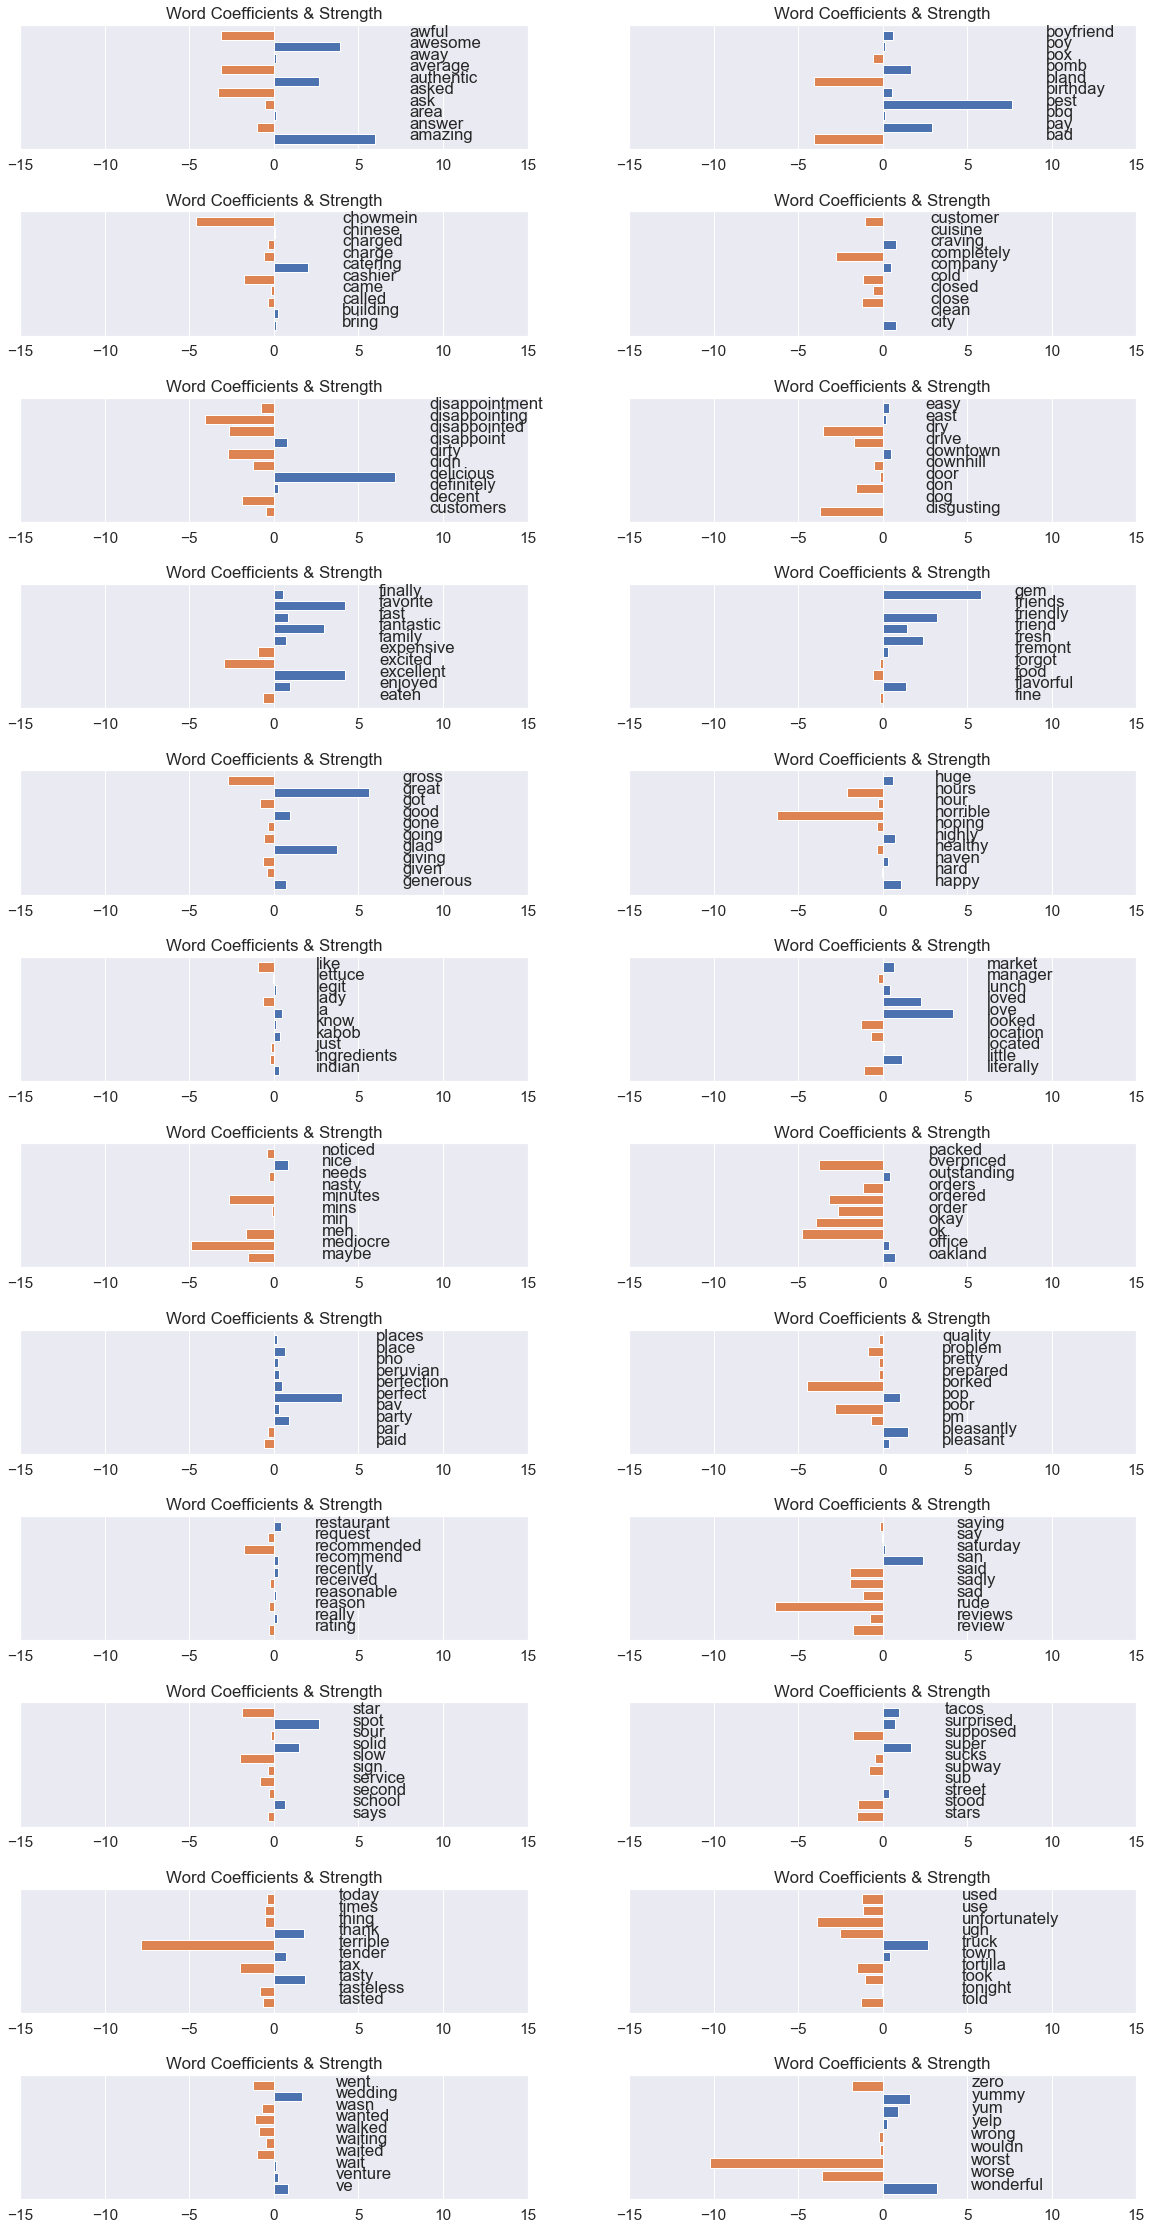

In [566]:
plt.figure(figsize=(20,40))
for i in plot_num:
    plt.subplot(row_num,2,i+1)
    try:
        plot_strength(strength, label, [i*10,(i*10)+10], [-15,15])
    except:
        plot_strength(strength, label, [i*10,(i*10)+9], [-15,15])
plt.subplots_adjust(hspace=0.5)

# Model - Deep Learning

In [571]:
from keras import preprocessing
from keras.preprocessing.text import Tokenizer

In [590]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, GRU, Dense, Conv1D, MaxPool1D

## Data Preparation

In [572]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(texts_labels.texts.values)

In [573]:
sequences = tokenizer.texts_to_sequences(texts_labels.texts.values)

In [574]:
texts_labels['sequence'] = sequences

In [580]:
train_data = texts_labels.iloc[:train_cutoff]
test_data = texts_labels.iloc[train_cutoff:]

In [584]:
x_train = preprocessing.sequence.pad_sequences(train_data['sequence'], 25)
x_test = preprocessing.sequence.pad_sequences(test_data['sequence'], 25)

y_train = train_data.binary_labels.values
y_test = test_data.binary_labels.values

## Model Setup

In [628]:
model = Sequential()

model.add(Embedding(10000, 32))

model.add(Conv1D(filters=32, kernel_size=5, activation='relu'))
model.add(MaxPool1D(2))

model.add(GRU(32))

model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

In [629]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, None, 32)          320000    
_________________________________________________________________
conv1d_11 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
gru_7 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_21 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_22 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 33        
Total para

In [630]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [631]:
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.1)

Train on 40397 samples, validate on 4489 samples
Epoch 1/10
40397/40397 [==============================] - 6s 154us/step - loss: 0.4876 - acc: 0.7600 - val_loss: 0.4328 - val_acc: 0.7988
Epoch 2/10
40397/40397 [==============================] - 5s 116us/step - loss: 0.3824 - acc: 0.8276 - val_loss: 0.4247 - val_acc: 0.7995
Epoch 3/10
40397/40397 [==============================] - 5s 118us/step - loss: 0.3418 - acc: 0.8479 - val_loss: 0.4059 - val_acc: 0.8082
Epoch 4/10
40397/40397 [==============================] - 5s 121us/step - loss: 0.2932 - acc: 0.8756 - val_loss: 0.3893 - val_acc: 0.8262
Epoch 5/10
40397/40397 [==============================] - 5s 123us/step - loss: 0.2378 - acc: 0.9027 - val_loss: 0.4028 - val_acc: 0.8314
Epoch 6/10
40397/40397 [==============================] - 5s 119us/step - loss: 0.1842 - acc: 0.9290 - val_loss: 0.4373 - val_acc: 0.8358
Epoch 7/10
40397/40397 [==============================] - 5s 125us/step - loss: 0.1355 - acc: 0.9508 - val_loss: 0.4763 - v

## Model Evaluation

### Validation vs Train

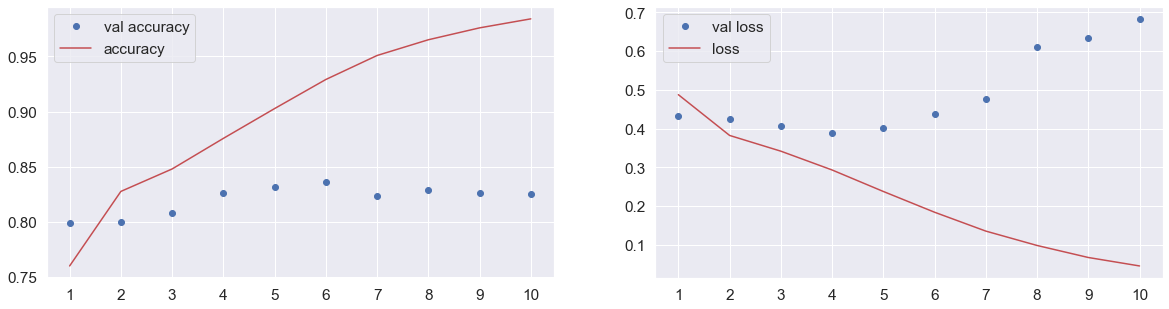

In [632]:
plt.figure(figsize=(20,5))

plt.subplot(121)
plt.plot(range(10), history.history['val_acc'], 'bo', label='val accuracy', color='b')
plt.plot(range(10), history.history['acc'], 'b', label='accuracy', color='r')
plt.xticks(range(0,10), range(1,21))
plt.legend()

plt.subplot(122)
plt.plot(range(10), history.history['val_loss'], 'bo', label='val loss', color='b')
plt.plot(range(10), history.history['loss'], 'b', label='loss', color='r')
plt.xticks(range(0,10), range(1,11))
plt.legend()
plt.show()

In [633]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test loss: {}\nTest accuracy: {}'.format(test_loss, test_acc))

11222/11222 [==============================] - 1s 66us/step
Test loss: 0.6935013577254395
Test accuracy: 0.8248084120902546


### Confusion Matrix & Precision and Recall

In [634]:
model_prediction = model.predict_classes(x_test)
model_prediction = [j for i in model_prediction for j in i]

In [635]:
con_matrix = confusion_matrix(y_test, model_prediction)

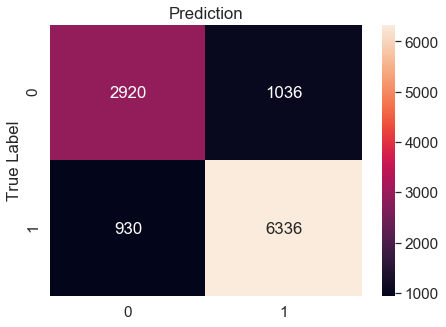

In [636]:
plt.figure(figsize=(7,5))
sns.set(font_scale=1.4)
sns.heatmap(con_matrix, annot=True, fmt="d")
plt.ylabel('True Label')
plt.title('Prediction')
plt.show()

In [637]:
class_report = classification_report(y_test, model_prediction, target_names=['negative_reveiws', 'positive_reviews'])
print(class_report)

                  precision    recall  f1-score   support

negative_reveiws       0.76      0.74      0.75      3956
positive_reviews       0.86      0.87      0.87      7266

        accuracy                           0.82     11222
       macro avg       0.81      0.81      0.81     11222
    weighted avg       0.82      0.82      0.82     11222



### ROC AUC

In [639]:
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(x_test))

In [640]:
auc_ = auc(fpr, tpr)

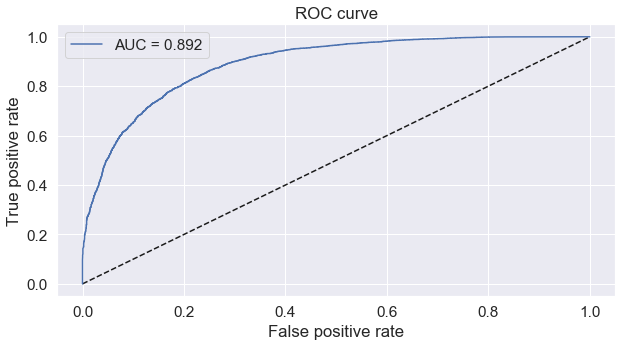

In [641]:
plt.figure(figsize=(10,5))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc_))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Prediction

In [642]:
def custom_prediction(sentence):
    """ prediction with your own sentense
    """
    sentence_seq = tokenizer.texts_to_sequences(np.array([sentence]))
    seq_num = preprocessing.sequence.pad_sequences(sentence_seq, 20)
    label = model.predict_classes(seq_num)[0][0]
    return label

In [643]:
sentence = 'the wait is so long but their food is awesome'
custom_prediction(sentence)

1